# Credit Card Default Data - Prepare Dataset for Analysis

These notebooks include application of decision trees, random forests, naive Bayes, support vector machines and neural networks for binary classification task. The data set used is credit card default data that includes 30,000 instances of customers and their credit history, and their credit default result. The response variable is a binary variable, which takes the value of 0 for payment on time and 1 for default. The purpose of the classification task is to predict whether a client will default on his payment (y=1), or pay on time (y=0) given information on their amount of credit, sex, education, marital status, age, history of past payment, amount of bill statement, and amount of previous payment. The dataset can be downloaded from the University of California Irvine Machine Learning Repository: 
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [1]:
#Integer division will return float value
from __future__ import division
#Import the libraries that will be used in the analysis.
#Import os to set working directory
import os as osvariable
#Set working directory
osvariable.chdir("C:/Users/Mustafa/Desktop/Github/Machine_Learning/Machine_Learning")
#Import numpy for array operations
import numpy as np
#Suppress scientific notation for numpy
np.set_printoptions(suppress=True)
#Import pandas
import pandas as pd
#Import read_csv to read in csv files
from pandas import read_csv
#Import plotting library
import matplotlib.pyplot as plt
%matplotlib inline
#Import decision tree
from sklearn import tree
#Import Random Forest
from sklearn.ensemble import RandomForestClassifier
#Import naive bayes
from sklearn.naive_bayes import GaussianNB
#Import support vector machines
from sklearn import svm
#Import my implementation of the neural network classifier
import neural_networks
#Import dummy classifier to compare classifier results to dummy classifier 
#to assess performance
from sklearn.dummy import DummyClassifier
#Import cross_validation for cross validating the models
from sklearn import cross_validation
#Import grid search for optimizing hyperparameters
from sklearn.grid_search import GridSearchCV
#train_test_split splits the data into train and test sets  
from sklearn.cross_validation import train_test_split
#VarianceThreshold removes variables with a variance lower than the 
#specified threshold
from sklearn.feature_selection import VarianceThreshold
#Import make_scorer to make a custom score object
from sklearn.metrics import make_scorer
#Import roc_curve and auc to calculate the area under the
#receiving operating characteristics curve
from sklearn.metrics import roc_curve, auc
#Import interpolate to draw the roc_curve
from scipy import interp
#Import the calibration curve to plot the predicted probabilities against
#observed probabilities
from sklearn.calibration import calibration_curve
#Import learning curve
from sklearn.learning_curve import learning_curve
#Import the classification report to report precision, recall, f-score and support
#for the classes
from sklearn.metrics import classification_report
#Import logistic regression and isotonic regression for probability calibration
from sklearn.linear_model import LogisticRegression as logistic_regression
from sklearn.isotonic import IsotonicRegression as isotonic_regression
#Import pydot to draw the decision tree
import pydot_ng
from sklearn.externals.six import StringIO
from IPython.display import Image
#Import the stats library to perform ttest
from scipy import stats
#Import 3D plot
from mpl_toolkits.mplot3d import Axes3D
#Import preprocessing for scaling data before calling some of the classifiers
from sklearn import preprocessing

In [2]:
# Read the csv file into 'default_data' data frame object
default_data = read_csv('default_of_credit_card_clients.csv')
#Take a look at the first 5 observations
print(default_data.head())

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

              ...              BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0             ...                      0          0          0         0   
1             ...                   3272       3455       3261         0   
2             ...                  14331      14948      15549      1518   
3             ...                  28314      28959      29547      2000   
4             ...                  20940      19146      19131      2000   

   PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0       689  

In [3]:
#Set the unique observation identifier as the pandas dataframe index 
default_data = default_data.set_index(default_data['ID'])
#Remove the identifier variable
default_data = default_data.drop(['ID'],axis = 1)
#Look at the shape of the data frame
print(np.shape(default_data))

(30000, 24)


In [4]:
#Separate the response variable from the dataframe
y = pd.DataFrame(default_data['default payment next month'],columns = ['default payment next month'],index = default_data.index.values)
X = default_data.drop(['default payment next month'],axis = 1)
X = X.set_index(default_data.index.values)

In [5]:
#Before proceeding, we will convert all data types to numeric types
#Take a look at the number of different data types
print('number of types')
print(pd.value_counts(default_data.dtypes))

number of types
int64    24
dtype: int64


In [6]:
#All types are numeric.
#Take a look at the number of unique values for each variable
for varname in X.columns.values:
    print('Variable:',varname,' ',len(np.unique(X[varname])))

('Variable:', 'LIMIT_BAL', ' ', 81)
('Variable:', 'SEX', ' ', 2)
('Variable:', 'EDUCATION', ' ', 7)
('Variable:', 'MARRIAGE', ' ', 4)
('Variable:', 'AGE', ' ', 56)
('Variable:', 'PAY_0', ' ', 11)
('Variable:', 'PAY_2', ' ', 11)
('Variable:', 'PAY_3', ' ', 11)
('Variable:', 'PAY_4', ' ', 11)
('Variable:', 'PAY_5', ' ', 10)
('Variable:', 'PAY_6', ' ', 10)
('Variable:', 'BILL_AMT1', ' ', 22723)
('Variable:', 'BILL_AMT2', ' ', 22346)
('Variable:', 'BILL_AMT3', ' ', 22026)
('Variable:', 'BILL_AMT4', ' ', 21548)
('Variable:', 'BILL_AMT5', ' ', 21010)
('Variable:', 'BILL_AMT6', ' ', 20604)
('Variable:', 'PAY_AMT1', ' ', 7943)
('Variable:', 'PAY_AMT2', ' ', 7899)
('Variable:', 'PAY_AMT3', ' ', 7518)
('Variable:', 'PAY_AMT4', ' ', 6937)
('Variable:', 'PAY_AMT5', ' ', 6897)
('Variable:', 'PAY_AMT6', ' ', 6939)


In [7]:
#Get the list of categorical variables and the continuous variables.
#We will treat PAY_0, PAY_2... variables as continuous. These are history of past 
#payment. The values of these parameters represent the number of months
#the payment was delayed. 
categorical_variables = np.array(['SEX', 'EDUCATION', 'MARRIAGE'])
continuous_variables = [variable for variable in X.columns.values if variable not in categorical_variables]

In [8]:
#Create the dictionary that will hold the categorical variable names
#as the key and the categories as values. The order of the values
#gives their code
labels_dictionary = {}
for varname in categorical_variables:
    labels_dictionary[varname] = pd.Categorical(X[varname]).categories 
    print(varname,labels_dictionary[varname])
    X[varname] = pd.Categorical(X[varname]).codes

('SEX', Int64Index([1, 2], dtype='int64'))
('EDUCATION', Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64'))
('MARRIAGE', Int64Index([0, 1, 2, 3], dtype='int64'))


In [9]:
#Print dictionary
print(labels_dictionary)

{'EDUCATION': Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64'), 'MARRIAGE': Int64Index([0, 1, 2, 3], dtype='int64'), 'SEX': Int64Index([1, 2], dtype='int64')}


In [10]:
#Drop variables whose variance is below a threshold.
#VarianceThreshold function returns the index of variables
#that have a variance higher than the threshold
#The VarianceThreshold with an empty argument only keeps
#variables with nonzero variance
#Create the VarianceThreshold object with the threshold
select_variance = VarianceThreshold()

In [11]:
#Fit the data
select_variance.fit(X)

VarianceThreshold(threshold=0.0)

In [12]:
#Print the names of the variables with 0 variance
#Use ~ sign before the boolean array to get the names 
#select_variance.fit assigns a value of True to variables with variances
#higher than the threshold to keep them, but we want to look at the 
#names of the variables with variances below the threshold
print('Zero variance variables')
print(X.columns.values[~select_variance.get_support(indices = False)])

Zero variance variables
[]


In [13]:
#Return a dataframe that only includes variables 
#with a higher than the threshold variance
#fit_transform returns an ndarray, convert it back to 
#a dataframe. Keep the column names for the variables which will be preserved
column_names = X.columns.values[select_variance.get_support(indices = False)]
X = pd.DataFrame(select_variance.fit_transform(X),columns = column_names,index = default_data.index.values)

In [14]:
#Get the correlation matrix in a dataframe
correlationfactor = np.corrcoef(X.T)

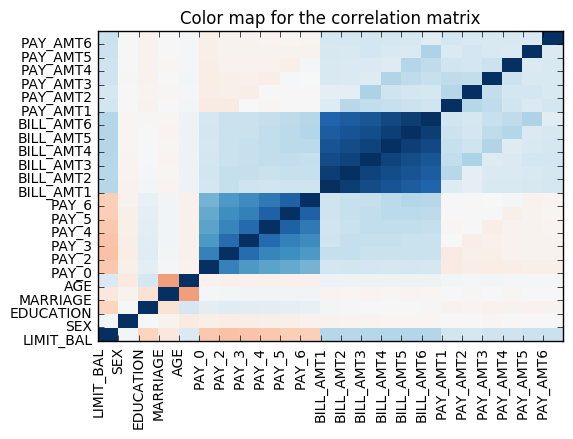

In [15]:
#Draw the color map for the correlation matrix to better visualize
#highly correlated variables 
dy = 1
dx = 1
y_corr, x_corr = np.mgrid[slice(0, X.shape[1] + dy, dy),
                slice(0, X.shape[1] + dx, dx)]
correlationfactor_min, correlationfactor_max = -np.abs(correlationfactor).max(), np.abs(correlationfactor).max()
plt.figure()
plt.xticks(range(X.shape[1]), X.columns.values, rotation='vertical')
plt.yticks(range(X.shape[1]), X.columns.values)
plt.pcolor(x_corr, y_corr, np.array(correlationfactor), cmap='RdBu', vmin=correlationfactor_min, vmax=correlationfactor_max)
plt.title('Color map for the correlation matrix')
plt.show()
plt.savefig('correlation_matrix')

In [16]:
correlationfactor = pd.DataFrame(np.corrcoef(X.T),columns = X.columns.values)

In [17]:
#Create a set of variables which are not higly correlated
#with at least one other variable
#We will retain these variables
correlation_below_threshold_set = set()
#Set the correlation_threshold
correlation_threshold = 0.90
column_index = 0
#For each variable in the dataset
for i in range(np.shape(X)[1]):
    #Add the variable to the set
    correlation_below_threshold_set.add(X.columns.values[i])
    #For each other variable in the dataset
    column_index = column_index + 1
    for j in range(column_index):
        #If the variable is not the current variable, and if the 
        #correlation is higher than the threshold, discard the variable
        #from the set        
        if (i<>j) and (correlationfactor.iloc[i,j] > correlation_threshold):
            print('High correlation:',correlationfactor.columns.values[i],
                    correlationfactor.columns.values[j],' %0.03f' % correlationfactor.iloc[i,j])
            correlation_below_threshold_set.discard(X.columns.values[i])

('High correlation:', 'BILL_AMT2', 'BILL_AMT1', ' 0.951')
('High correlation:', 'BILL_AMT3', 'BILL_AMT2', ' 0.928')
('High correlation:', 'BILL_AMT4', 'BILL_AMT3', ' 0.924')
('High correlation:', 'BILL_AMT5', 'BILL_AMT4', ' 0.940')
('High correlation:', 'BILL_AMT6', 'BILL_AMT4', ' 0.901')
('High correlation:', 'BILL_AMT6', 'BILL_AMT5', ' 0.946')


In [18]:
#Print the set of variables with correlation above a threshold
print(correlation_below_threshold_set)

set(['AGE', 'SEX', 'PAY_6', 'PAY_4', 'PAY_5', 'PAY_2', 'PAY_3', 'PAY_0', 'BILL_AMT1', 'PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1', 'LIMIT_BAL', 'MARRIAGE', 'EDUCATION'])


In [19]:
#Check the correlation of each variable with the outcome
correlations = []  
for i in range(np.shape(X)[1]):
    correlations.append(np.corrcoef(X.iloc[:,i],np.ravel(y))[0,1])

In [20]:
#Sort correlations with the outcome and print
correlations_df = pd.DataFrame.from_items([('Variable_name',X.columns.values),('Correlation',correlations)])
correlations_df = correlations_df.sort_values(by = 'Correlation', axis = 0, ascending = False)
pd.DataFrame(correlations_df).to_csv('Correlations.csv',index = False)
print(correlations_df)

   Variable_name  Correlation
5          PAY_0     0.324794
6          PAY_2     0.263551
7          PAY_3     0.235253
8          PAY_4     0.216614
9          PAY_5     0.204149
10         PAY_6     0.186866
2      EDUCATION     0.028006
4            AGE     0.013890
16     BILL_AMT6    -0.005372
15     BILL_AMT5    -0.006760
14     BILL_AMT4    -0.010156
13     BILL_AMT3    -0.014076
12     BILL_AMT2    -0.014193
11     BILL_AMT1    -0.019644
3       MARRIAGE    -0.024339
1            SEX    -0.039961
22      PAY_AMT6    -0.053183
21      PAY_AMT5    -0.055124
19      PAY_AMT3    -0.056250
20      PAY_AMT4    -0.056827
18      PAY_AMT2    -0.058579
17      PAY_AMT1    -0.072929
0      LIMIT_BAL    -0.153520


Mean difference by payment status
('LIMIT_BAL', 't-statistic: 28.952', 'p-value 0.000')
('AGE', 't-statistic: -2.320', 'p-value 0.020')
('PAY_0', 't-statistic: -48.619', 'p-value 0.000')
('PAY_2', 't-statistic: -38.695', 'p-value 0.000')
('PAY_3', 't-statistic: -34.536', 'p-value 0.000')
('PAY_4', 't-statistic: -31.021', 'p-value 0.000')
('PAY_5', 't-statistic: -28.888', 'p-value 0.000')
('PAY_6', 't-statistic: -26.702', 'p-value 0.000')
('BILL_AMT1', 't-statistic: 3.398', 'p-value 0.001')
('BILL_AMT2', 't-statistic: 2.447', 'p-value 0.014')
('BILL_AMT3', 't-statistic: 2.459', 'p-value 0.014')
('BILL_AMT4', 't-statistic: 1.759', 'p-value 0.079')
('BILL_AMT5', 't-statistic: 1.162', 'p-value 0.245')
('BILL_AMT6', 't-statistic: 0.930', 'p-value 0.352')
('PAY_AMT1', 't-statistic: 17.513', 'p-value 0.000')
('PAY_AMT2', 't-statistic: 14.817', 'p-value 0.000')
('PAY_AMT3', 't-statistic: 11.893', 'p-value 0.000')
('PAY_AMT4', 't-statistic: 12.222', 'p-value 0.000')
('PAY_AMT5', 't-statistic: 1

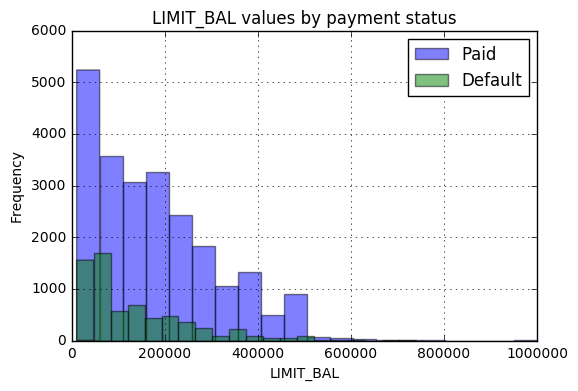

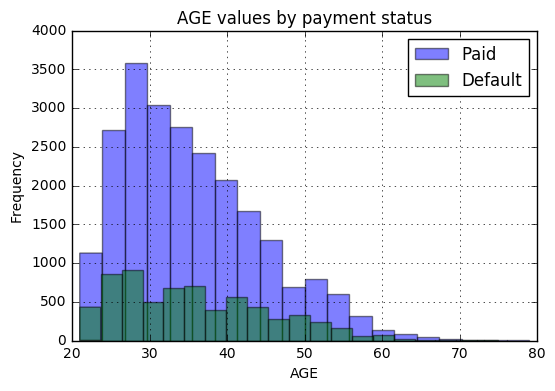

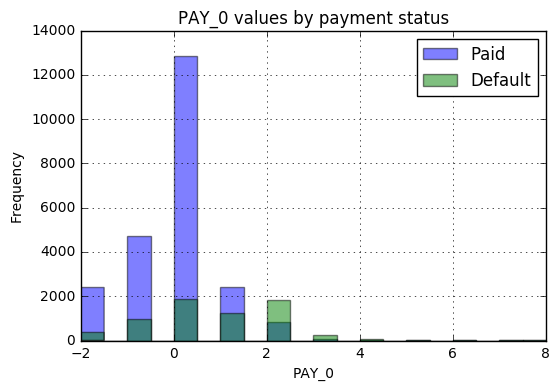

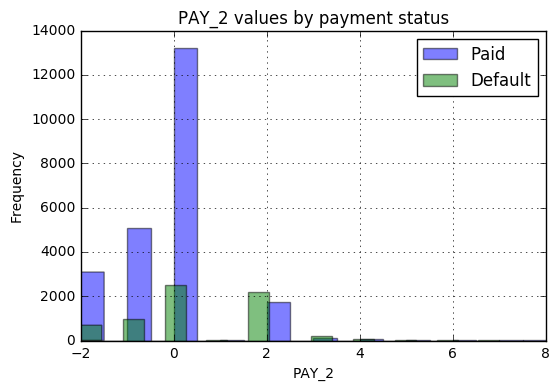

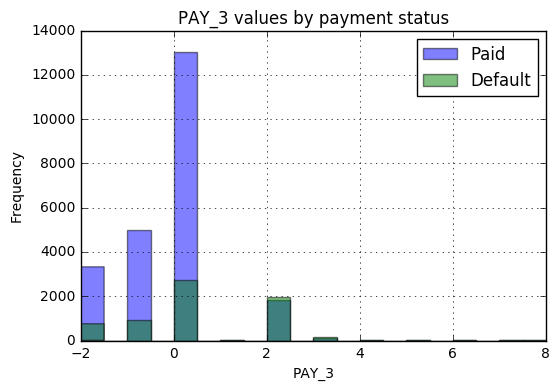

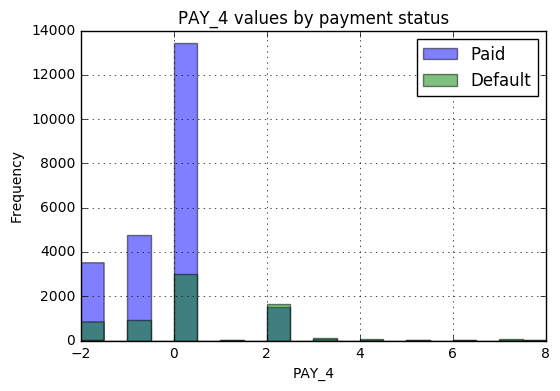

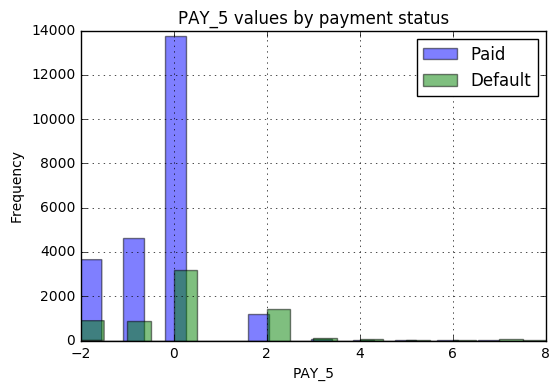

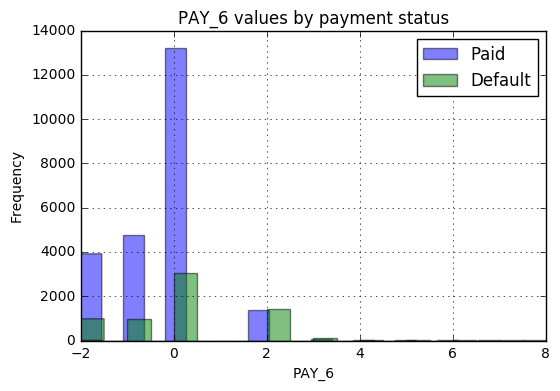

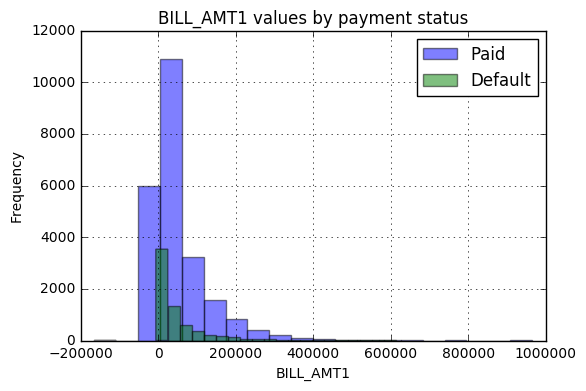

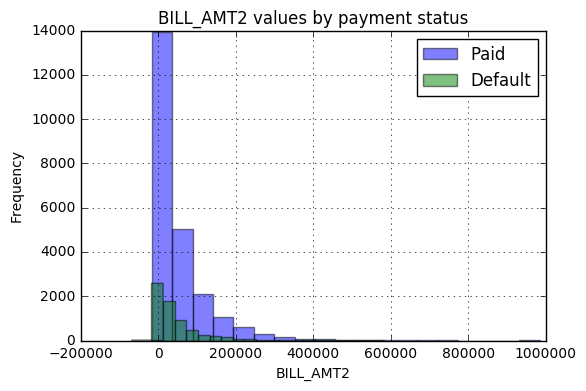

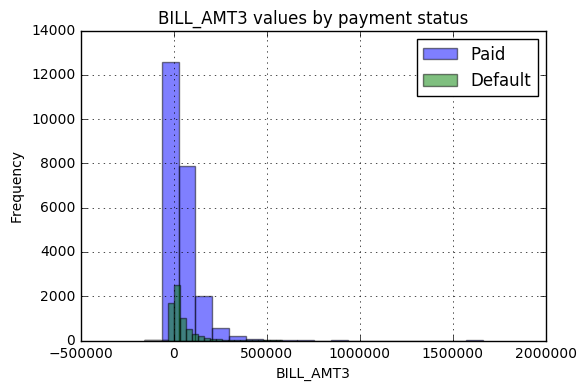

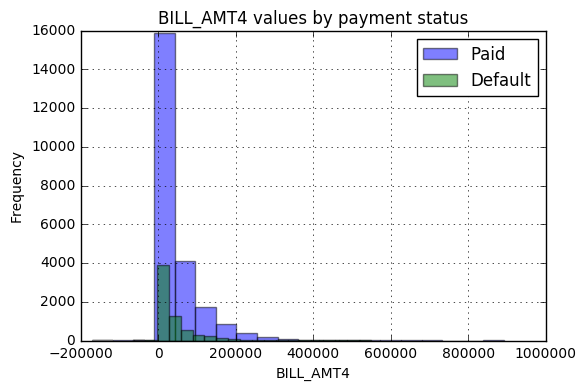

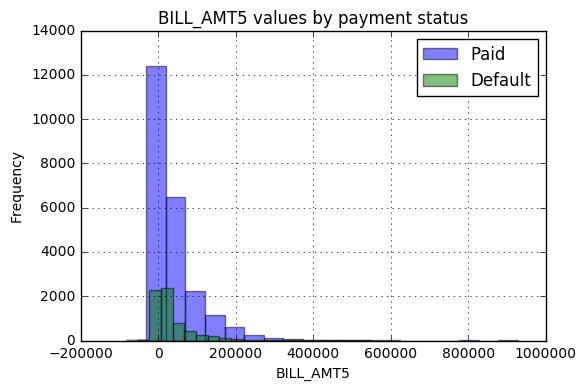

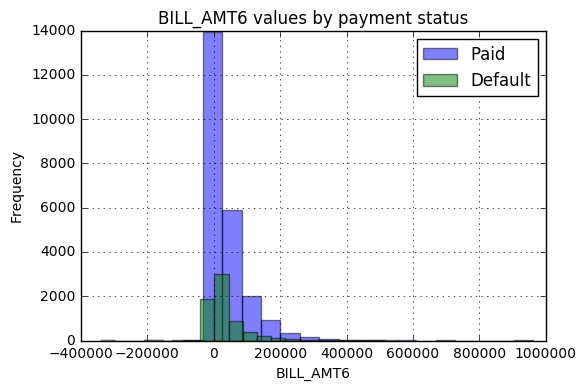

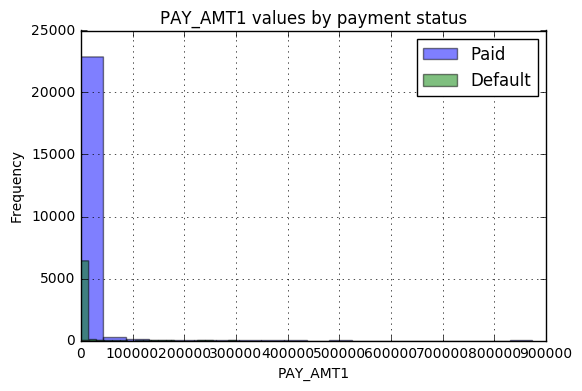

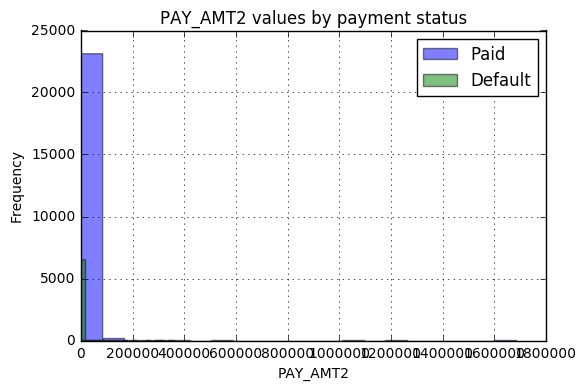

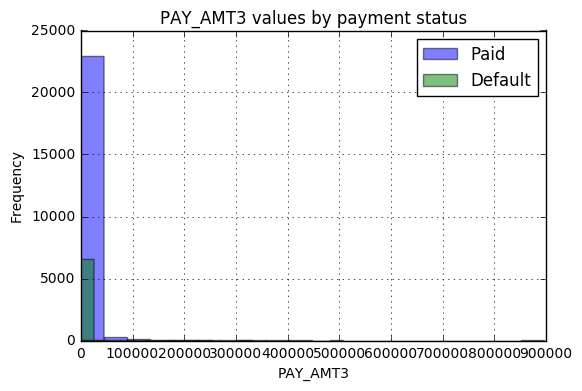

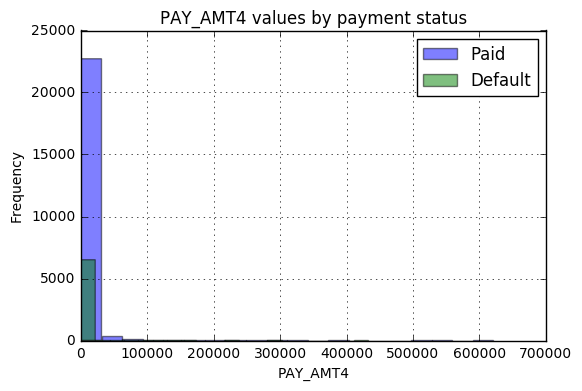

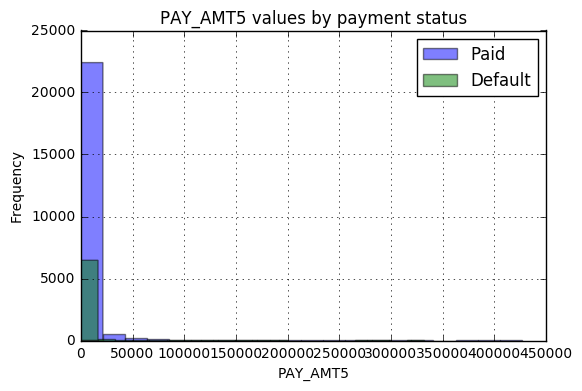

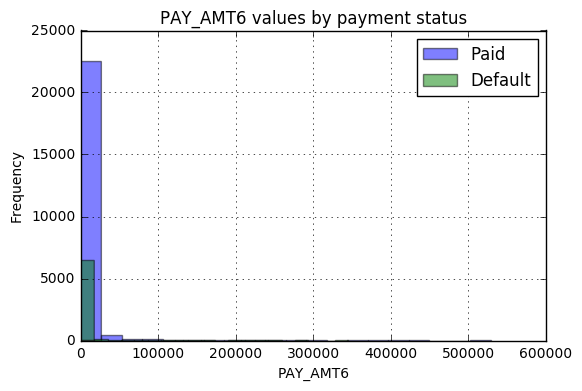

In [21]:
#Summarize age by patient status (outcome)
#Get mean age by status
#Perform ttest on the difference of continuous variables by response
#and plot the histogram of continuous variables by payment status
print('Mean difference by payment status')
for varname in continuous_variables:
    ttest_status_t,ttest_status_p  = stats.ttest_ind(X.loc[(np.ravel(y) == 0),[varname]],X.loc[(np.ravel(y) == 1),[varname]],equal_var = False)
    print(varname,'t-statistic: %0.03f' % ttest_status_t,'p-value %0.03f' % ttest_status_p)
    #Histogram of age by default status
    plt.figure()
    X[(np.ravel(y) == 0)][varname].hist(bins = 20, alpha = 0.5, label = 'Paid')
    X[(np.ravel(y) == 1)][varname].hist(bins = 20, alpha = 0.5, label = 'Default')
    plt.title(str(varname) + ' values by payment status')
    plt.ylabel('Frequency')
    plt.xlabel(varname)
    plt.legend(loc = 'upper right')
    plt.savefig(varname)

In [22]:
#For categorical variables, whose name we saved in labels_dictionary,
#create dummy variables, remove the first dummy variable to make it the  
#reference category and remove the original variables
for key in labels_dictionary:
    dummy_variables = pd.get_dummies(X[key])
    removed_reference = False
    for var in dummy_variables:
        if removed_reference == False:
            removed_reference = True
        else:
            #Combine the variable name with the category
            varname = str(key) + '_' + str(labels_dictionary.get(key)[var])
            X[varname] = dummy_variables[var]

In [23]:
#Remove the variables for which we have created dummy variables
X = X.drop(list(labels_dictionary.keys()), axis = 1)
#Write the dataframes that we will use in the analysis
X.to_csv('X.csv',index = False)
y.to_csv('y.csv',index = False)

In [24]:
#Convert the response variable to a numpy array. The response variable
#has to be one dimensional to work with Scikit learn
#Store the variable names in a list first
variable_names = list(X.columns.values)

X = np.array(X)
y = np.ravel(np.array(y))

In [25]:
#We will assume that a false positive costs $5,000
#and a false negative costs $15,000, just to illustrate 
#cost-sensitive learning. We assume that the cost
#of true predictions is zero. For a disccussion of 
#cost-sensitive lerning; see Elkan, "Foundations of 
#Cost-Sensitive Learning" 
cost_false_positive = 5000
cost_false_negative = 15000
cost_true_negative = 0
cost_true_positive = 0

In [26]:
#Before starting to work with the classifiers, 
#we can define our score function which we will 
#use to evaluate the classifiers
def expected_cost(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    proportion_true = np.sum(ground_truth)/len(ground_truth)
    proportion_false = 1 - proportion_true
    true_positive = np.sum((ground_truth + predictions) == 2)
    false_positive = np.sum((ground_truth - predictions) == -1)
    false_negative = np.sum((ground_truth - predictions) == 1)
    true_negative = len(ground_truth) - true_positive - false_positive - false_negative  
    if (true_positive + false_negative) != 0:
        false_negative_rate = false_negative / (true_positive + false_negative)
        true_positive_rate = true_positive / (true_positive + false_negative)
    else:
        false_negative_rate = 0
        true_positive_rate = 0
    if (false_positive + true_negative) != 0:
        false_positive_rate = false_positive / (false_positive + true_negative)
        true_negative_rate = true_negative / (false_positive + true_negative)
    else:
        false_positive_rate = 0
        true_negative_rate = 0
    cost_error = cost_false_positive * false_positive_rate * proportion_false +     cost_false_negative * false_negative_rate * proportion_true +     cost_true_positive * true_positive_rate * proportion_true +     cost_true_negative * true_negative_rate * proportion_false
    return cost_error  

In [27]:
def confusion_matrix_custom(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    true_positive = np.sum((ground_truth + predictions) == 2)
    false_positive = np.sum((ground_truth - predictions) == -1)
    false_negative = np.sum((ground_truth - predictions) == 1)
    true_negative = (len(ground_truth) - true_positive - false_positive - false_negative )
    if (true_positive + false_negative) != 0:
        false_negative_rate = false_negative / (true_positive + false_negative)
    else:
        false_negative_rate = 0
    true_positive_rate = 1 - false_negative_rate
    if (false_positive + true_negative) != 0:
        false_positive_rate = false_positive / (false_positive + true_negative)
    else:
        false_positive_rate = 0    
    true_negative_rate = 1 - false_positive_rate 
    confusion_matrix = np.array([[true_positive_rate, false_positive_rate],[false_negative_rate, true_negative_rate]])      
    #               True    False
    #Test positive   TP      FP  
    #Test negative   FN      TN
    return confusion_matrix 

In [28]:
#Set the threshold for classifying the observations as true.
threshold_cost = (cost_false_positive + cost_true_negative) / (cost_false_positive - cost_true_negative + cost_false_negative - cost_true_positive)
threshold_05 = 0.5

In [29]:
#Greater is better = False indicates that the result of the cost function is a loss
#the scorer negates the result of the custom loss function, and the highest negated
#value is the best score, which is equivalent to the lowest non-negated value 
score_cost = make_scorer(expected_cost, greater_is_better = False)

In [30]:
#Split the data into a train_validation and test sets. We will use the train_validation
#set to optimize the hyperparameters using crossvalidation, and the final score for the 
#model will be calculated on the test data set.  
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [31]:
#We will perform cross-validation with 5 folds
#Get 5 folds
n_folds = 5
cv = cross_validation.StratifiedKFold(y_train_validation, n_folds = n_folds, random_state = 1)

In [32]:
#To calibrate predicted probabilities, we can use Platt's method, 
#which fits a logistic regression to the outcomes using the 
#uncalibrated probabilities
lr = logistic_regression()

In [33]:
#Another method of probability calibration is the isotonic regression 
ir = isotonic_regression(out_of_bounds = 'clip')

In [34]:
#we will compare the expected cost of each classifier to that of a dummy
#classifier which simply assigns all observations to the majority class
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf = clf.fit(X_train_validation, y_train_validation)
clf_predictions = clf.predict(X_test)